# Zero-shot Quantification

In [1]:
import os
import glob
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    jaccard_score,
)

# -----------------------------
# Paths
# -----------------------------
DATA_ROOT = "/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches"
PRED_ROOT = "/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_zeroshot"

DATASETS = [
    "amyloid_plaque_patches",
    "c_fos_positive_patches",
    "cell_nucleus_patches",
    "vessels_patches",
]

MODELS = ["image_clip", "image_only", "random"]


# -----------------------------
# Utils
# -----------------------------
def load_nifti(path):
    return nib.load(path).get_fdata().astype(np.float32)


def dice_numpy(pred, gt, eps=1e-8):
    pred = pred.astype(bool)
    gt   = gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    return (2 * inter) / (pred.sum() + gt.sum() + eps)


# -----------------------------
# Metric computation
# -----------------------------
rows = []

for dataset in DATASETS:
    print(f"\nProcessing dataset: {dataset}")
    gt_dir   = os.path.join(DATA_ROOT, dataset)
    pred_dir = os.path.join(PRED_ROOT, dataset)

    gt_files = sorted(glob.glob(os.path.join(gt_dir, "*_label.nii.gz")))

    for gt_path in gt_files:
        base = os.path.basename(gt_path).replace("_label.nii.gz", "")
        gt = load_nifti(gt_path).astype(bool)

        for model in MODELS:
            pred_path = os.path.join(pred_dir, f"{base}_pred_{model}.nii.gz")
            prob_path = os.path.join(pred_dir, f"{base}_prob_{model}.nii.gz")

            if not (os.path.exists(pred_path) and os.path.exists(prob_path)):
                continue

            pred = load_nifti(pred_path).astype(bool)
            prob = load_nifti(prob_path)

            gt_flat   = gt.flatten()
            pred_flat = pred.flatten()
            prob_flat = prob.flatten()

            # Binary metrics
            dice = dice_numpy(pred, gt)
            iou  = jaccard_score(gt_flat, pred_flat)
            prec = precision_score(gt_flat, pred_flat, zero_division=0)
            rec  = recall_score(gt_flat, pred_flat, zero_division=0)

            # Threshold-free metrics
            try:
                roc = roc_auc_score(gt_flat, prob_flat)
            except ValueError:
                roc = np.nan

            try:
                pr = average_precision_score(gt_flat, prob_flat)
            except ValueError:
                pr = np.nan

            rows.append({
                "dataset": dataset,
                "patch": base,
                "model": model,
                "dice": dice,
                "iou": iou,
                "precision": prec,
                "recall": rec,
                "roc_auc": roc,
                "pr_auc": pr,
            })




Processing dataset: amyloid_plaque_patches

Processing dataset: c_fos_positive_patches

Processing dataset: cell_nucleus_patches

Processing dataset: vessels_patches


,dataset,patch,model,dice,iou,precision,recall,roc_auc,pr_auc
0,amyloid_plaque_patches,patch_000_vol000_ch0,image_clip,0.014142,0.007122,0.007155,0.602370,0.814371,0.005779
1,amyloid_plaque_patches,patch_000_vol000_ch0,image_only,0.017433,0.008793,0.008846,0.596209,0.835885,0.006695
2,amyloid_plaque_patches,patch_000_vol000_ch0,random,0.018618,0.009396,0.009462,0.574408,0.848089,0.007283
3,amyloid_plaque_patches,patch_001_vol011_ch0,image_clip,0.004632,0.002321,0.002321,1.000000,0.988462,0.022045
4,amyloid_plaque_patches,patch_001_vol011_ch0,image_only,0.002920,0.001462,0.001462,0.992754,0.967241,0.010060


dataset       model      dice                 iou  \
                                            mean       std      mean   
0   amyloid_plaque_patches  image_clip  0.017975  0.036995  0.009425   
1   amyloid_plaque_patches  image_only  0.016627  0.030860  0.008627   
2   amyloid_plaque_patches      random  0.017561  0.035306  0.009182   
3   c_fos_positive_patches  image_clip  0.060274  0.059777  0.031815   
4   c_fos_positive_patches  image_only  0.026934  0.029359  0.013820   
5   c_fos_positive_patches      random  0.023911  0.040364  0.012423   
6     cell_nucleus_patches  image_clip  0.453074  0.082960  0.296525   
7     cell_nucleus_patches  image_only  0.432405  0.091129  0.280013   
8     cell_nucleus_patches      random  0.429283  0.089156  0.277252   
9          vessels_patches  image_clip  0.263019  0.200959  0.167244   
10         vessels_patches  image_only  0.233140  0.208827  0.148655   
11         vessels_patches      random  0.250213  0.200487  0.158311   

             precision              recall             roc_auc            \
         std      mean       std      mean       std      mean       std   
0   0.020172  0.009503  0.020461  0.716394  0.337711  0.894774  0.093769   
1   0.016531  0.008679  0.016692  0.680668  0.344937  0.890674  0.083709   
2   0.019179  0.009243  0.019399  0.735393  0.341531  0.891102  0.092194   
3   0.032096  0.032612  0.032186  0.442093  0.458283  0.773582  0.154609   
4   0.015152  0.015133  0.016572  0.132240  0.120738  0.591759  0.122548   
5   0.021102  0.012714  0.021140  0.226230  0.423562  0.604739  0.262727   
6   0.070734  0.313066  0.078752  0.869629  0.097735  0.975778  0.018336   
7   0.074897  0.295838  0.082811  0.861473  0.082694  0.971987  0.018429   
8   0.072667  0.292105  0.084112  0.881386  0.101050  0.974141  0.020300   
9   0.141348  0.583726  0.399371  0.207657  0.194386  0.708615  0.279471   
10  0.145922  0.539368  0.401301  0.184236  0.205249  0.666559  0.292239   
11  0.137954  0.575216  0.407648  0.213062  0.223424  0.684798  0.292273   

      pr_auc            
        mean       std  
0   0.022134  0.044755  
1   0.034273  0.077929  
2   0.017402  0.042807  
3   0.077983  0.057863  
4   0.023326  0.012431  
5   0.058578  0.075597  
6   0.570392  0.144352  
7   0.508117  0.139366  
8   0.558279  0.145286  
9   0.414327  0.266767  
10  0.383890  0.267886  
11  0.400867  0.269762


=== Mean Dice by dataset ===

amyloid_plaque_patches
  image_clip  : 0.018 ± 0.037
  image_only  : 0.017 ± 0.031
  random      : 0.018 ± 0.035

c_fos_positive_patches
  image_clip  : 0.060 ± 0.060
  image_only  : 0.027 ± 0.029
  random      : 0.024 ± 0.040

cell_nucleus_patches
  image_clip  : 0.453 ± 0.083
  image_only  : 0.432 ± 0.091
  random      : 0.429 ± 0.089

vessels_patches
  image_clip  : 0.263 ± 0.201
  image_only  : 0.233 ± 0.209
  random      : 0.250 ± 0.200


<Figure size 1000x3000 with 0 Axes>

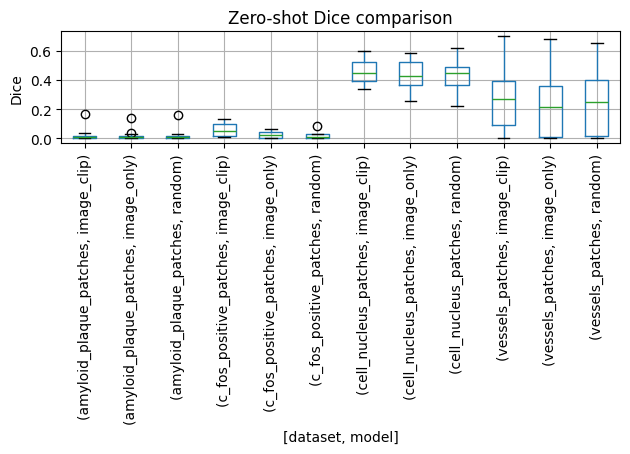

In [2]:
# -----------------------------
# Results table
# -----------------------------
df = pd.DataFrame(rows)
display(df.head())


# -----------------------------
# Aggregate summary
# -----------------------------
metric_cols = [
    "dice",
    "iou",
    "precision",
    "recall",
    "roc_auc",
    "pr_auc",
]

summary = (
    df
    .groupby(["dataset", "model"])[metric_cols]
    .agg(["mean", "std"])
    .reset_index()
)

display(summary)



# -----------------------------
# Quick printout (Dice)
# -----------------------------
print("\n=== Mean Dice by dataset ===")
for dataset in DATASETS:
    print(f"\n{dataset}")
    sub = df[df["dataset"] == dataset]
    for model in MODELS:
        m = sub[sub["model"] == model]["dice"]
        print(f"  {model:12s}: {m.mean():.3f} ± {m.std():.3f}")


# -----------------------------
# Optional: boxplot visualization
# -----------------------------
plt.figure(figsize=(10,30))
df.boxplot(column="dice", by=["dataset", "model"], rot=90)
plt.title("Zero-shot Dice comparison")
plt.suptitle("")
plt.ylabel("Dice")
plt.tight_layout()
plt.show()


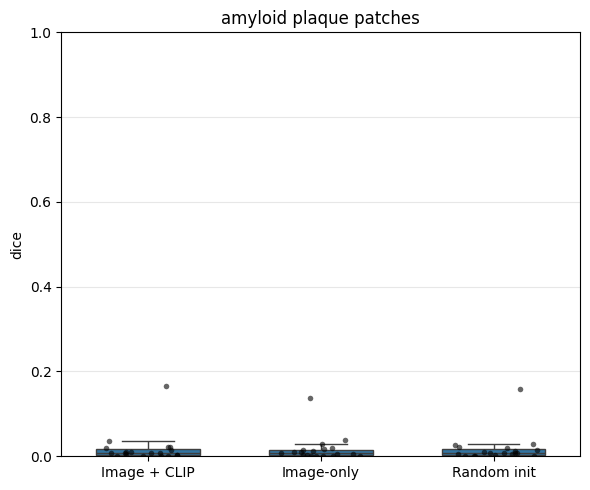

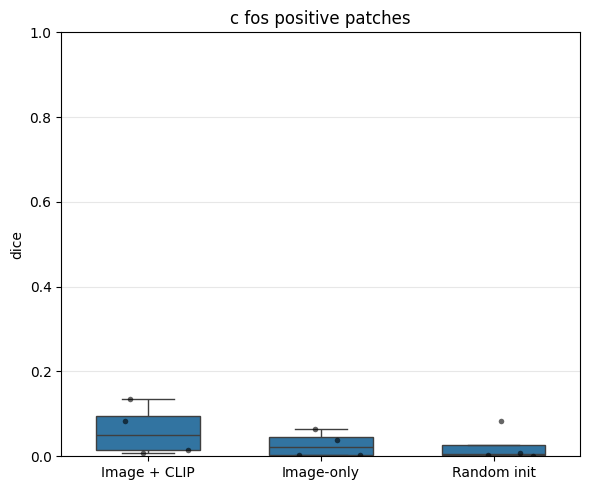

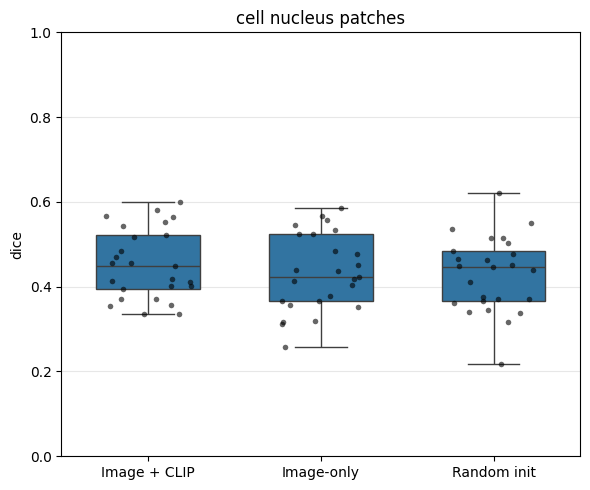

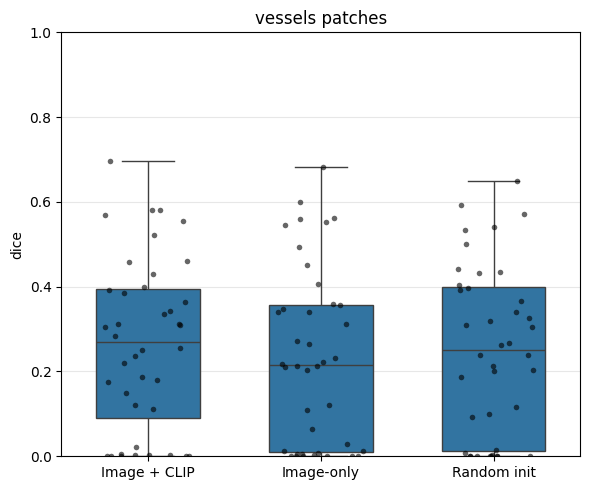

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Consistent ordering across plots
MODEL_ORDER = ["image_clip", "image_only", "random"]

# Optional: nicer model labels
MODEL_LABELS = {
    "image_clip": "Image + CLIP",
    "image_only": "Image-only",
    "random": "Random init",
}

def boxplot_with_points_per_dataset(df, metric="dice", save_dir=None):
    datasets = sorted(df["dataset"].unique())

    for dataset in datasets:
        sub = df[df["dataset"] == dataset].copy()

        plt.figure(figsize=(6, 5))

        # Boxplot
        sns.boxplot(
            data=sub,
            x="model",
            y=metric,
            order=MODEL_ORDER,
            showfliers=False,
            width=0.6,
        )

        # Overlay individual points
        sns.stripplot(
            data=sub,
            x="model",
            y=metric,
            order=MODEL_ORDER,
            color="black",
            alpha=0.6,
            jitter=0.25,
            size=4,
        )

        # Labels and formatting
        plt.title(f"{dataset.replace('_', ' ')}")
        plt.xlabel("")
        plt.ylabel(metric)
        plt.ylim(0, 1)
        plt.grid(axis="y", alpha=0.3)

        # Replace x-axis labels with nicer names
        plt.xticks(
            ticks=range(len(MODEL_ORDER)),
            labels=[MODEL_LABELS[m] for m in MODEL_ORDER],
        )

        plt.tight_layout()

        # Optional save
        if save_dir is not None:
            os.makedirs(save_dir, exist_ok=True)
            out_path = os.path.join(
                save_dir, f"{dataset}_{metric}_boxplot.png"
            )
            plt.savefig(out_path, dpi=300)
            print(f"Saved: {out_path}")

        plt.show()


# ---------
# Run it
# ---------
boxplot_with_points_per_dataset(df, metric="dice")


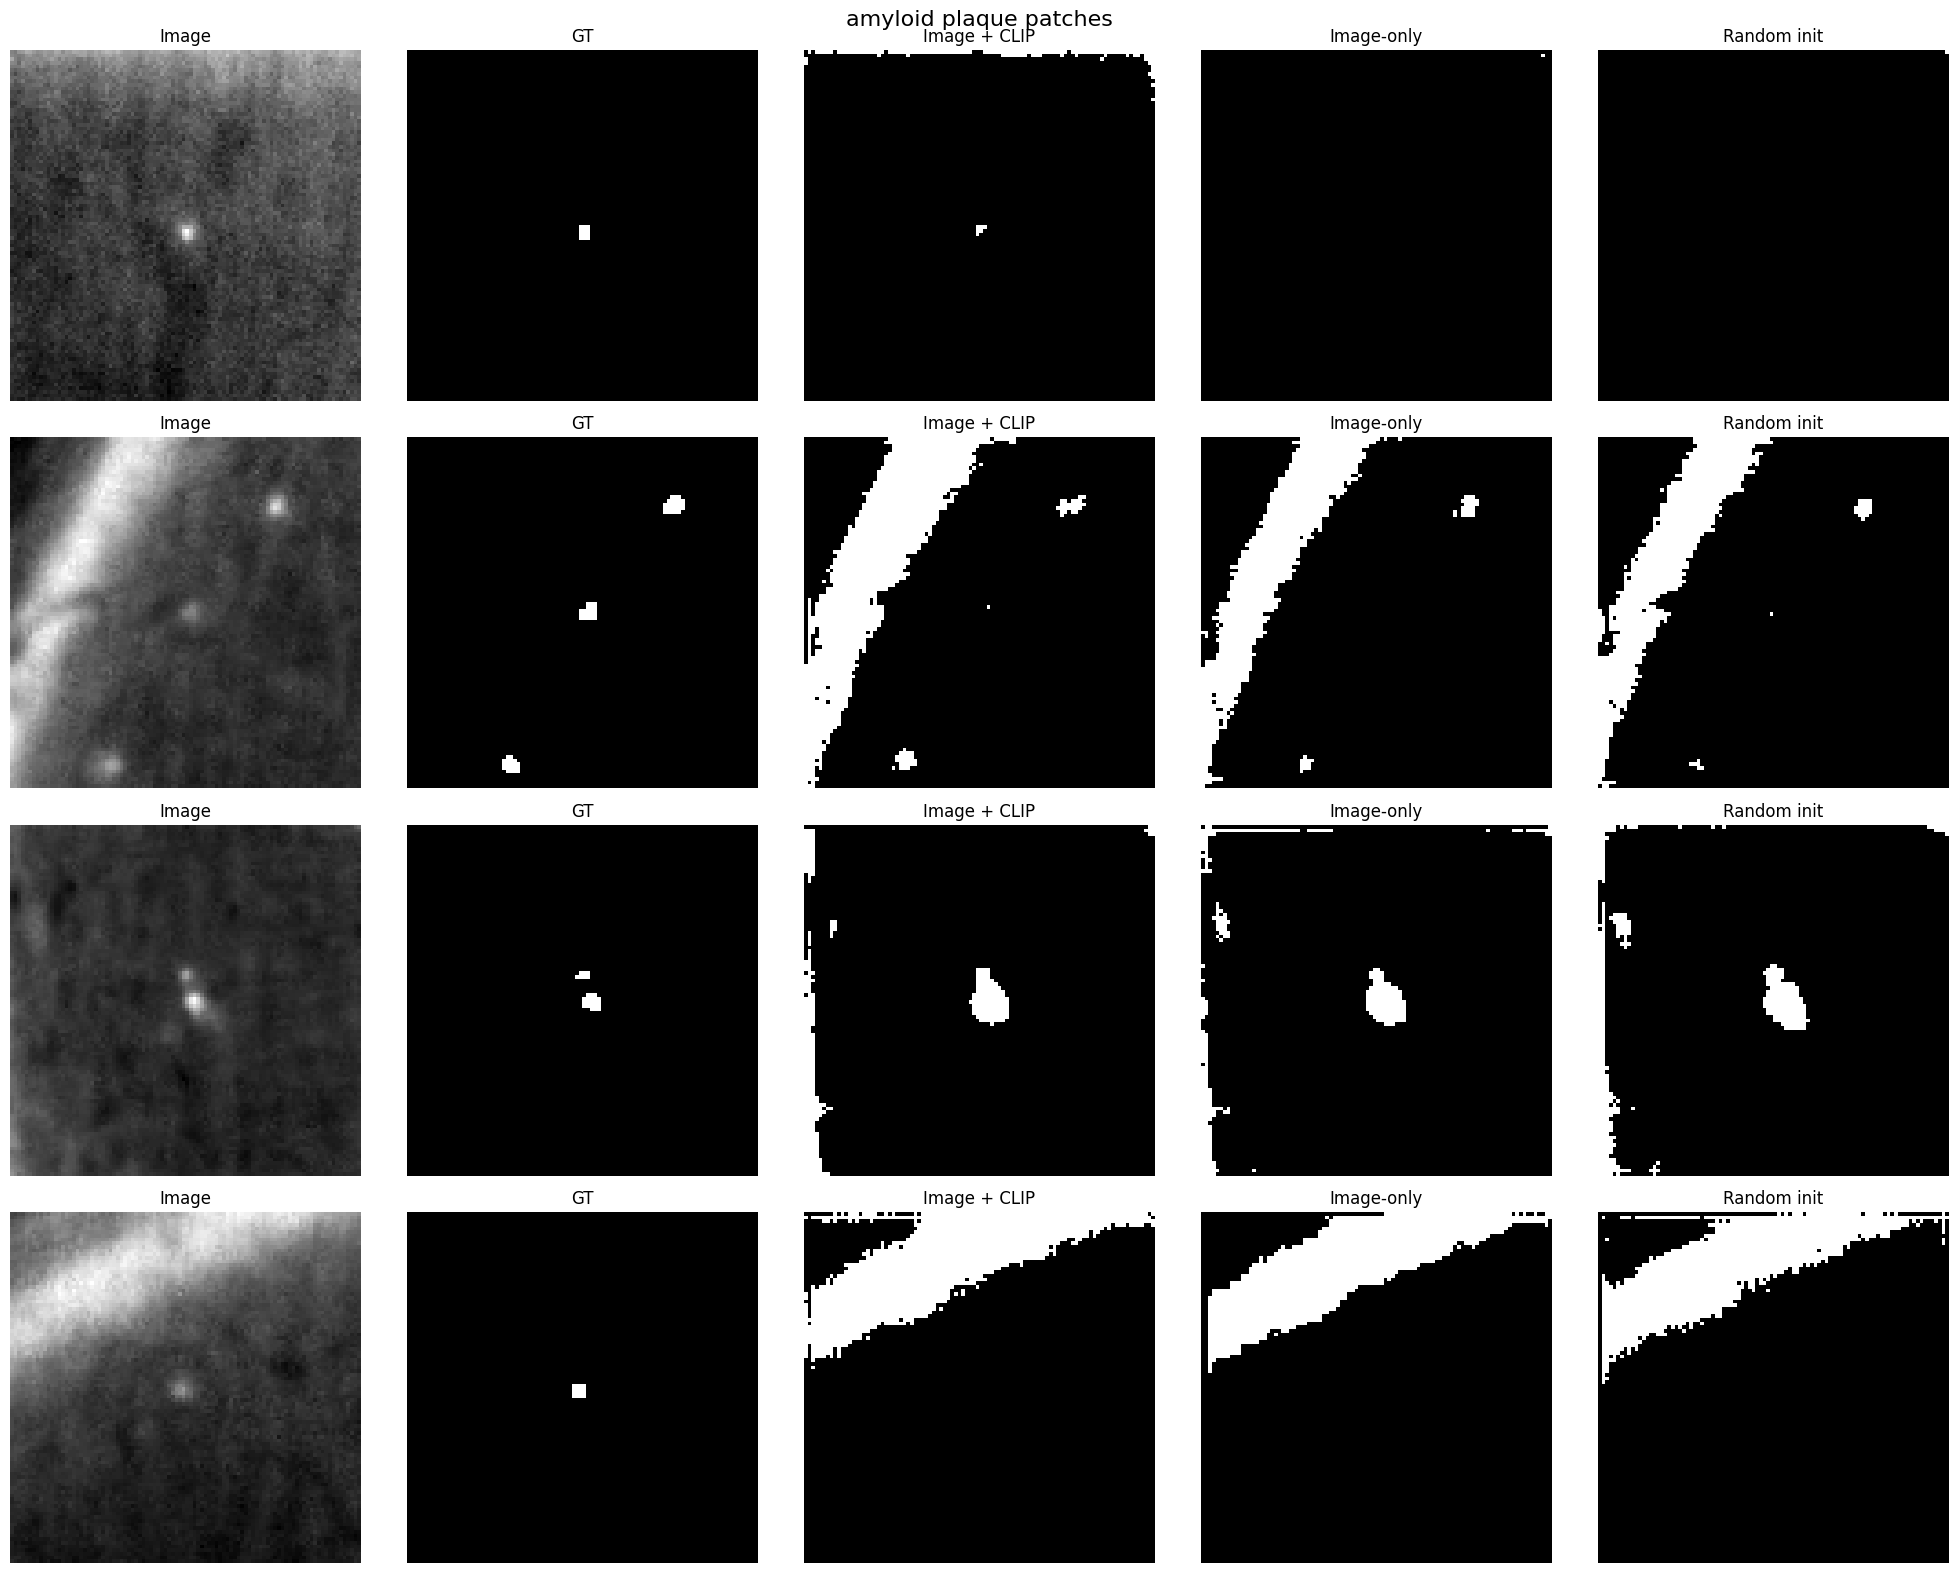

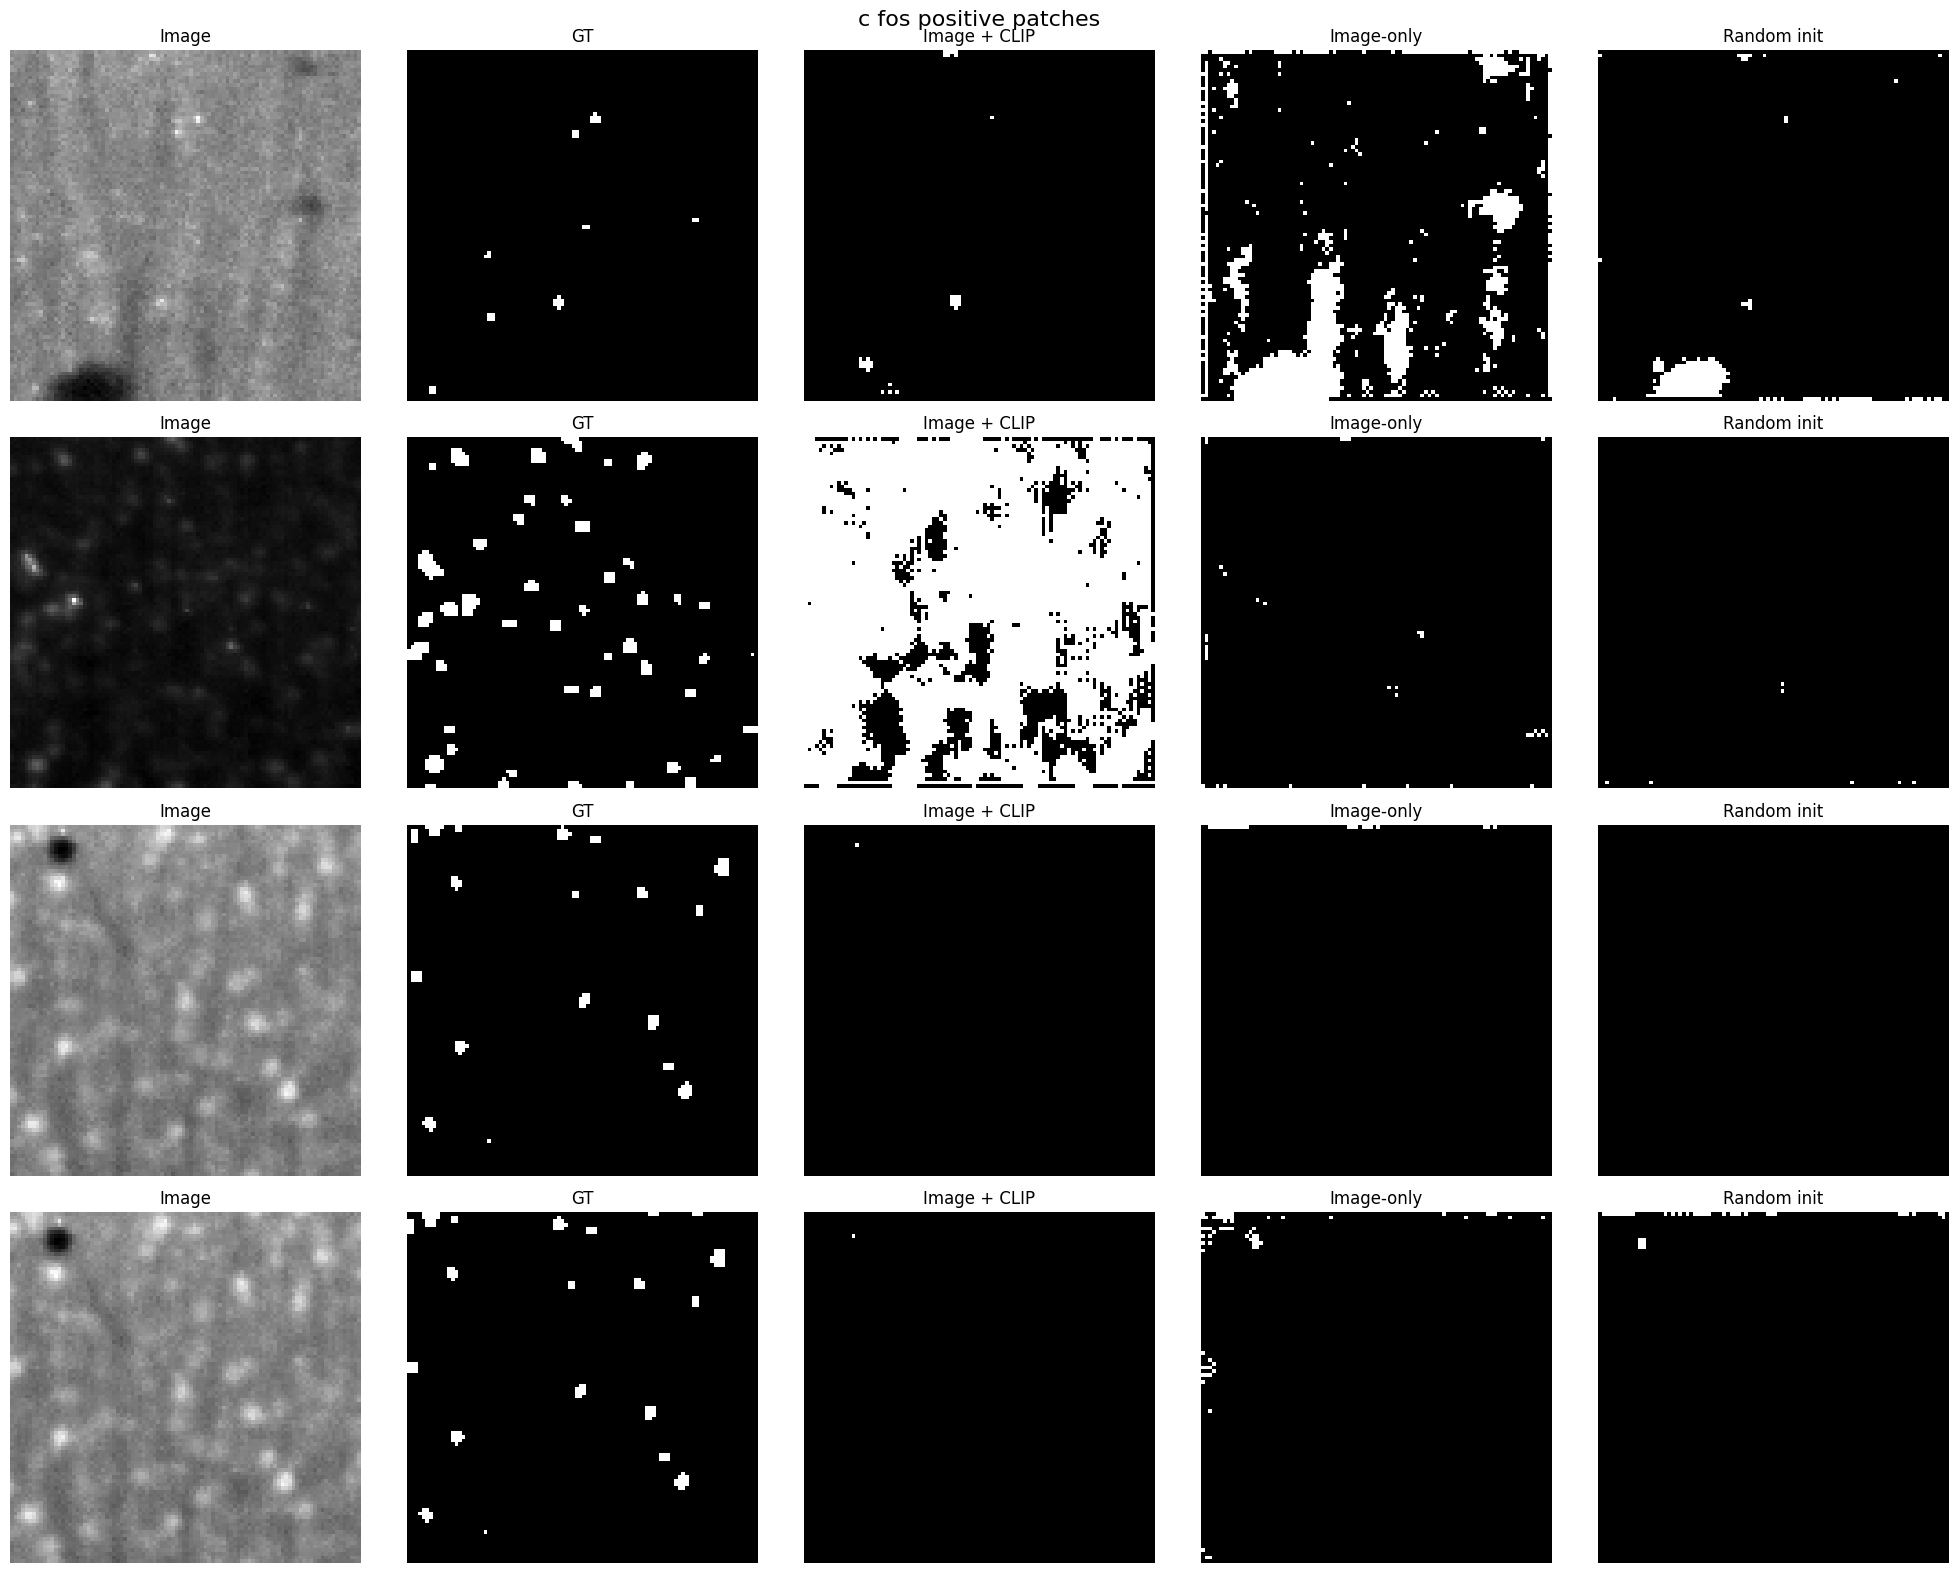

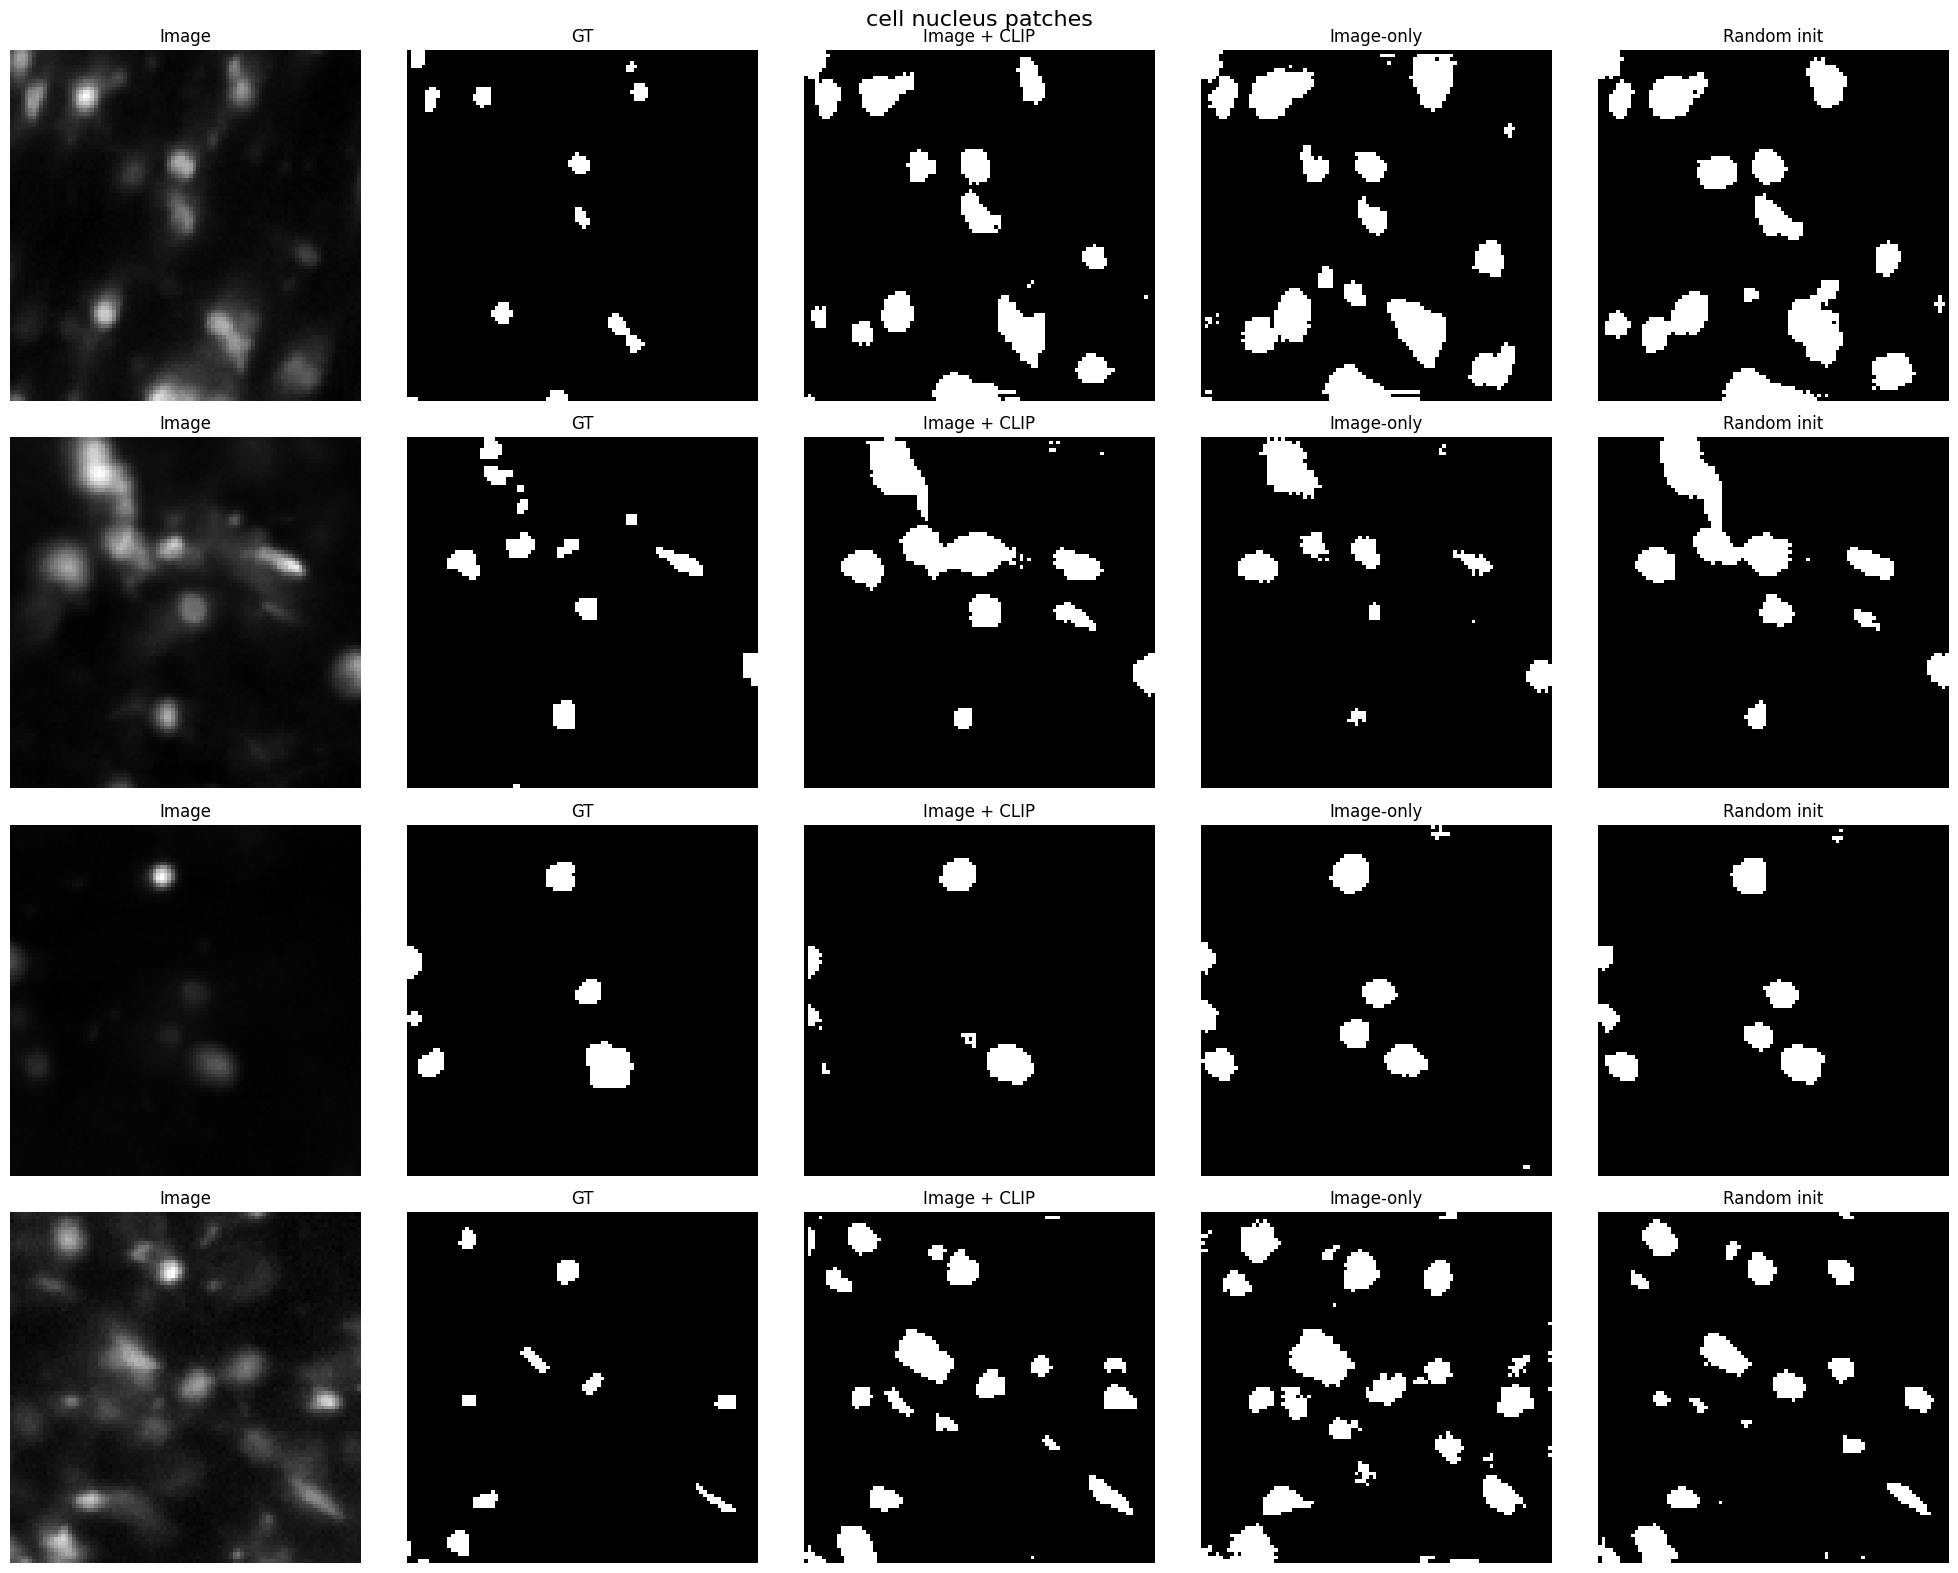

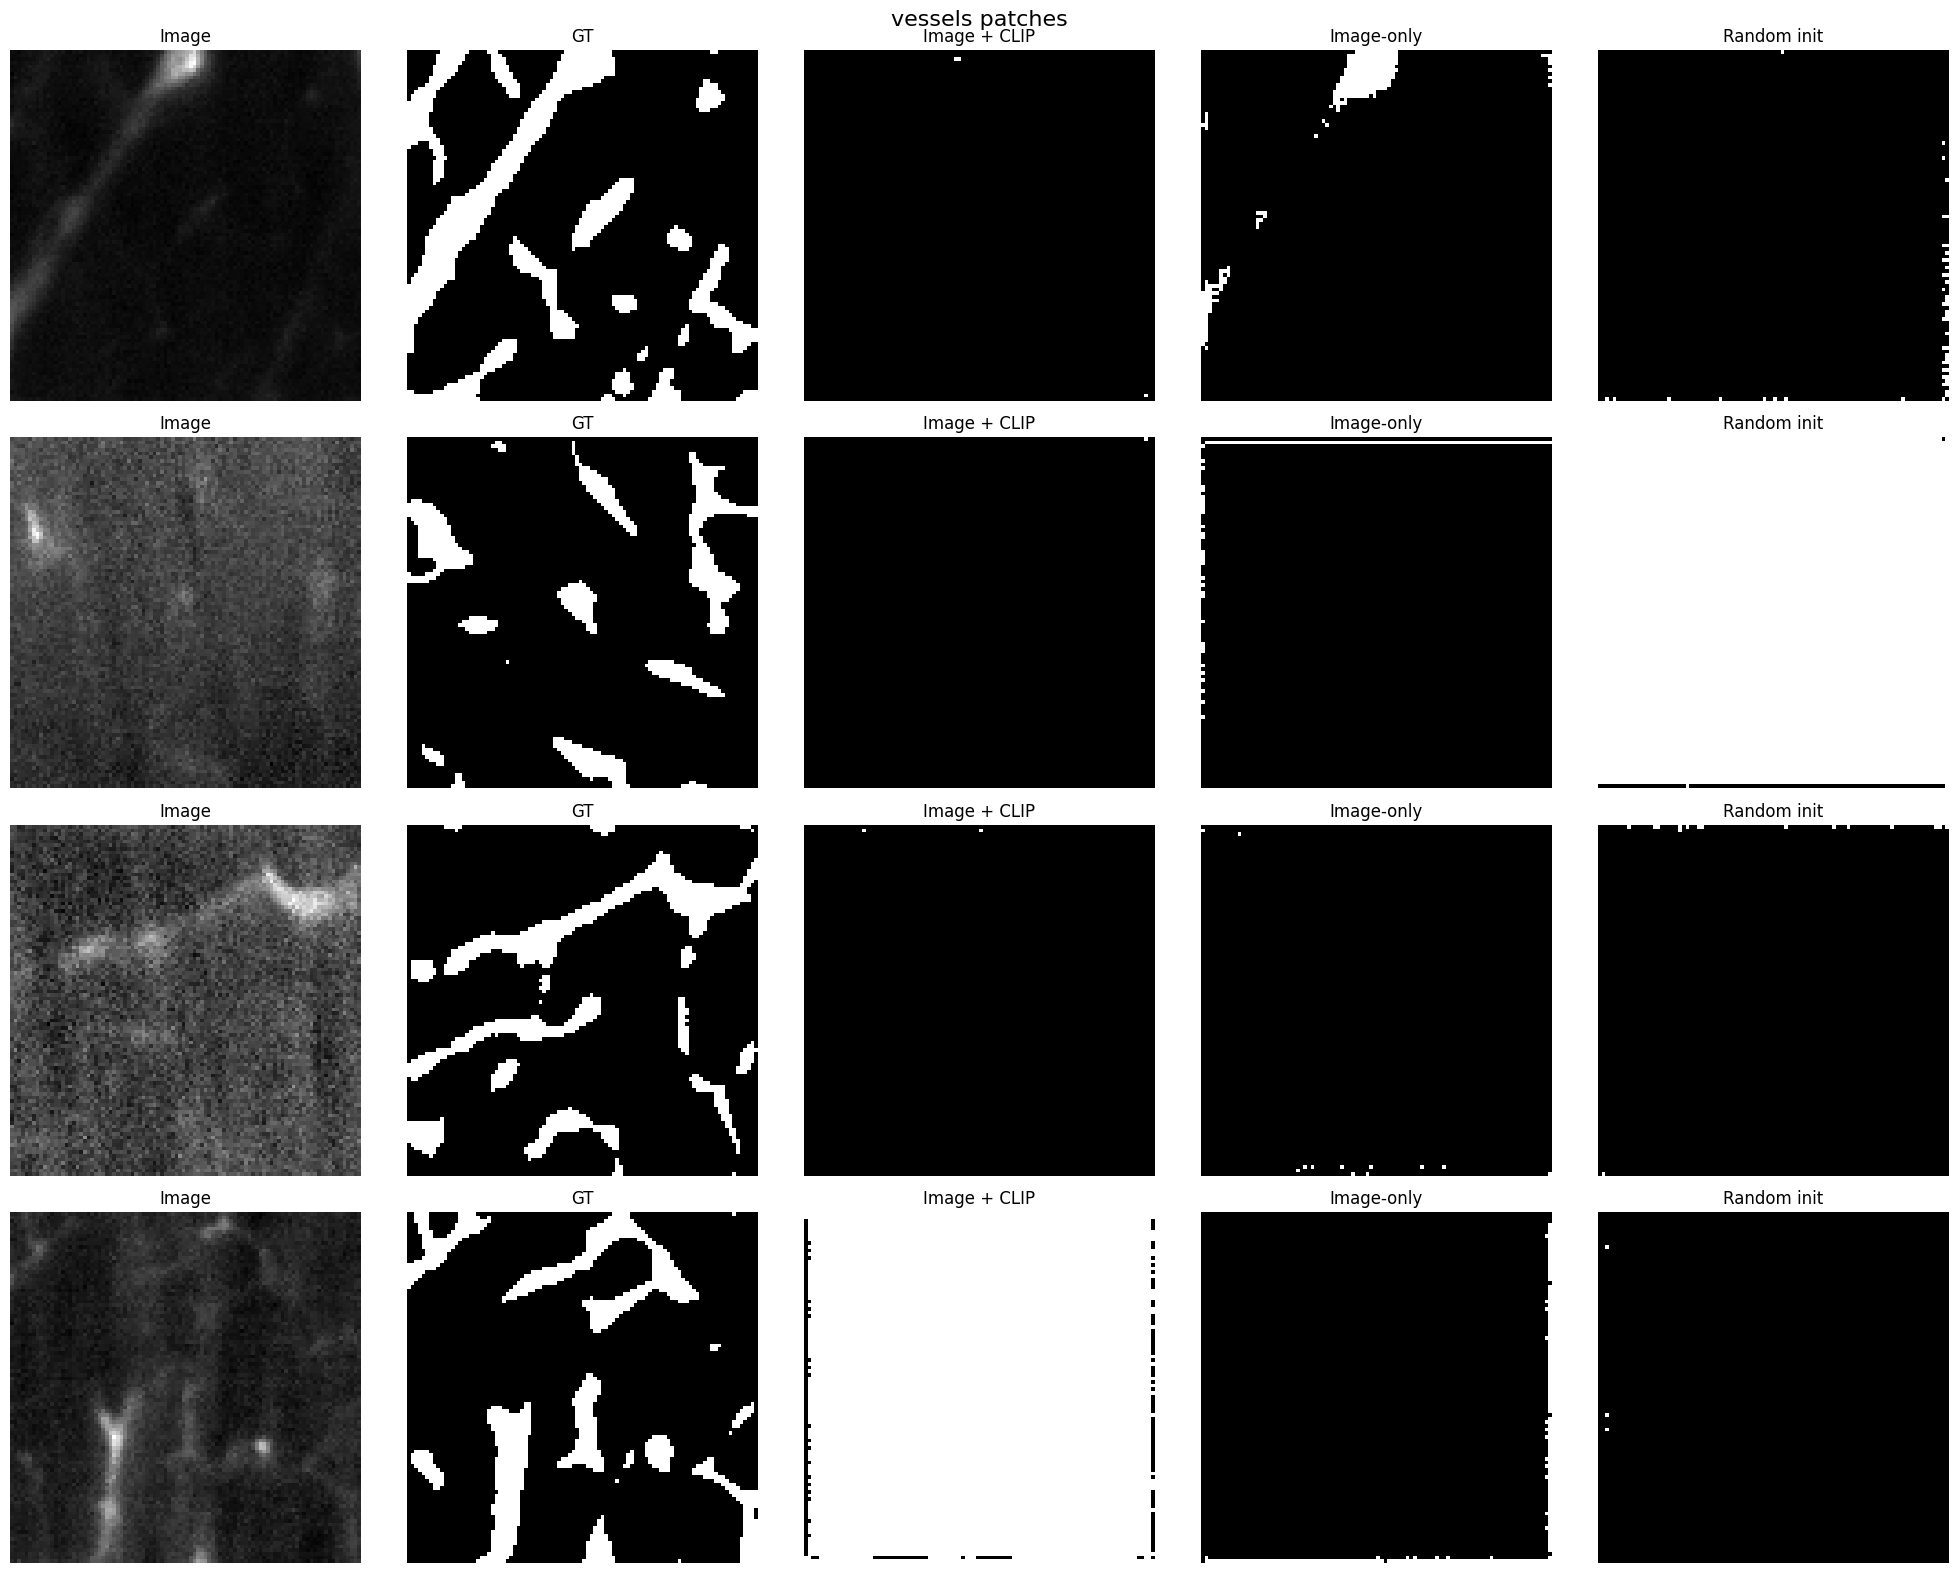

In [4]:
import os
import glob
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# -----------------------------
# Paths
# -----------------------------
DATA_ROOT = "/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches"
PRED_ROOT = "/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_zeroshot"

DATASETS = [
    "amyloid_plaque_patches",
    "c_fos_positive_patches",
    "cell_nucleus_patches",
    "vessels_patches",
]

MODELS = ["image_clip", "image_only", "random"]

MODEL_TITLES = {
    "image_clip": "Image + CLIP",
    "image_only": "Image-only",
    "random": "Random init",
}

# -----------------------------
# Utils
# -----------------------------
def load_nifti(path):
    return nib.load(path).get_fdata().astype(np.float32)

def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)


# -----------------------------
# Visualization
# -----------------------------
def show_random_examples(dataset, n_examples=4, seed=0):
    random.seed(seed)

    img_dir  = os.path.join(DATA_ROOT, dataset)
    pred_dir = os.path.join(PRED_ROOT, dataset)

    img_files = sorted(
        f for f in glob.glob(os.path.join(img_dir, "*.nii.gz"))
        if not f.endswith("_label.nii.gz")
    )

    chosen = random.sample(img_files, min(n_examples, len(img_files)))

    n_cols = 2 + len(MODELS)  # image + GT + preds
    fig, axes = plt.subplots(
        nrows=len(chosen),
        ncols=n_cols,
        figsize=(4*n_cols, 4*len(chosen))
    )

    if len(chosen) == 1:
        axes = axes[None, :]  # keep 2D indexing

    for row, img_path in enumerate(chosen):
        base = os.path.basename(img_path).replace(".nii.gz", "")

        img = normalize(load_nifti(img_path))
        gt  = load_nifti(os.path.join(img_dir, f"{base}_label.nii.gz"))

        z = img.shape[-1] // 2

        # ---- Image ----
        axes[row, 0].imshow(img[:, :, z], cmap="gray")
        axes[row, 0].set_title("Image")

        # ---- Ground truth ----
        axes[row, 1].imshow(gt[:, :, z], cmap="gray")
        axes[row, 1].set_title("GT")

        # ---- Predictions ----
        for col, model in enumerate(MODELS):
            pred_path = os.path.join(
                pred_dir, f"{base}_pred_{model}.nii.gz"
            )

            if os.path.exists(pred_path):
                pred = load_nifti(pred_path)
                axes[row, 2+col].imshow(pred[:, :, z], cmap="gray")
            else:
                axes[row, 2+col].text(
                    0.5, 0.5, "MISSING",
                    ha="center", va="center"
                )

            axes[row, 2+col].set_title(MODEL_TITLES[model])

        for a in axes[row]:
            a.axis("off")

    plt.suptitle(dataset.replace("_", " "), fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# Run for all datasets
# -----------------------------
for dataset in DATASETS:
    show_random_examples(dataset, n_examples=4, seed=42)


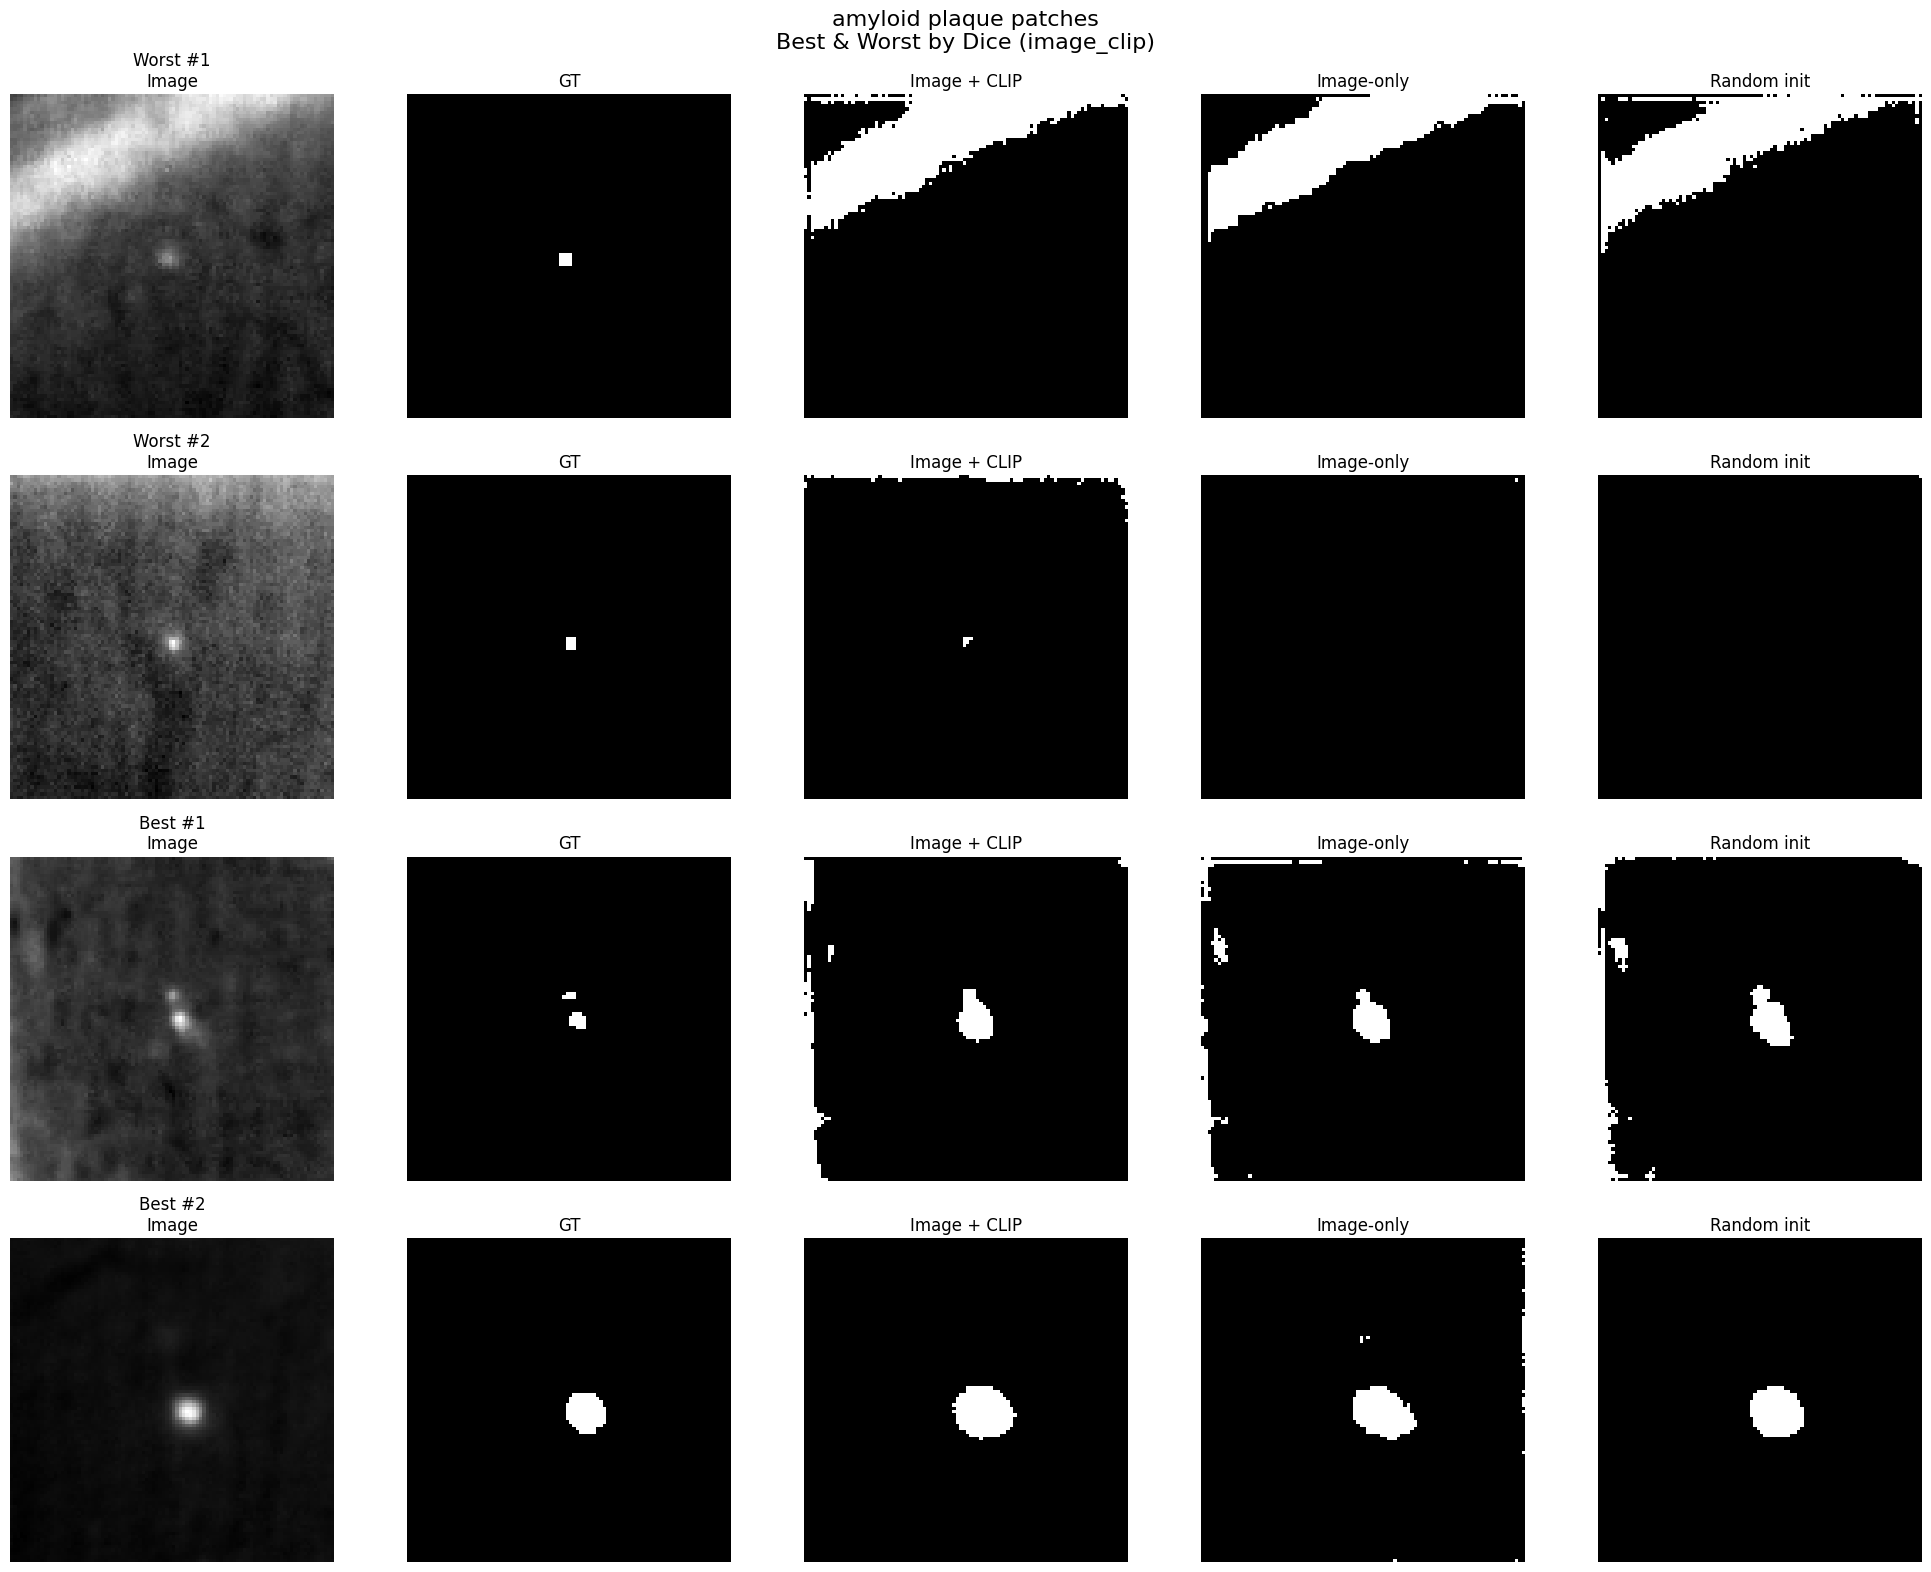

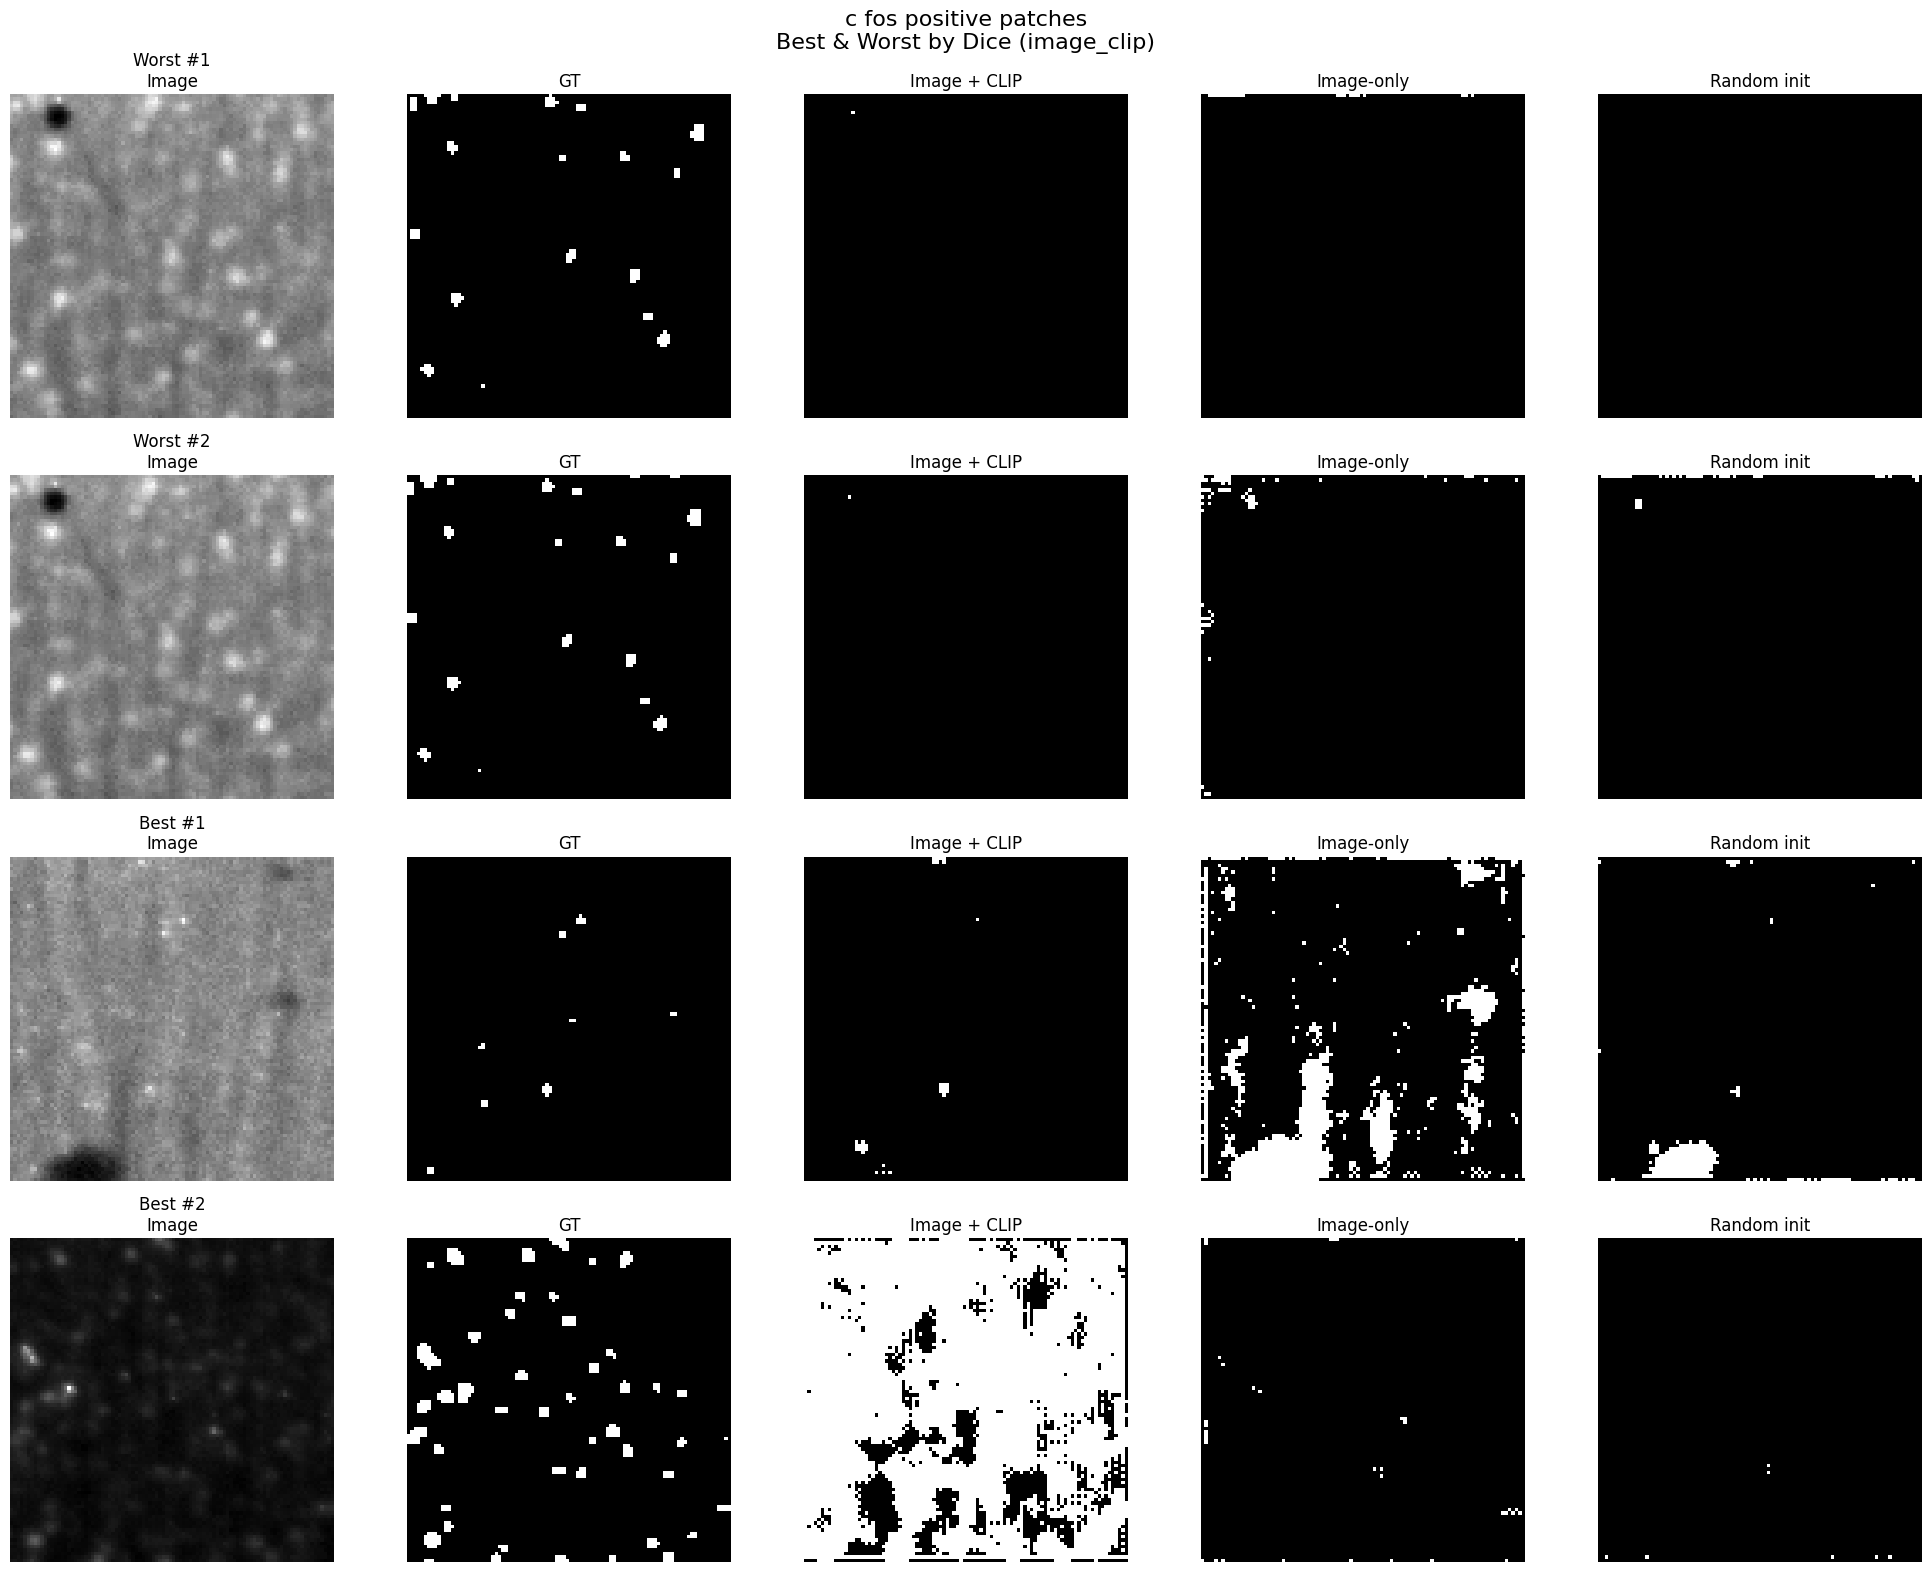

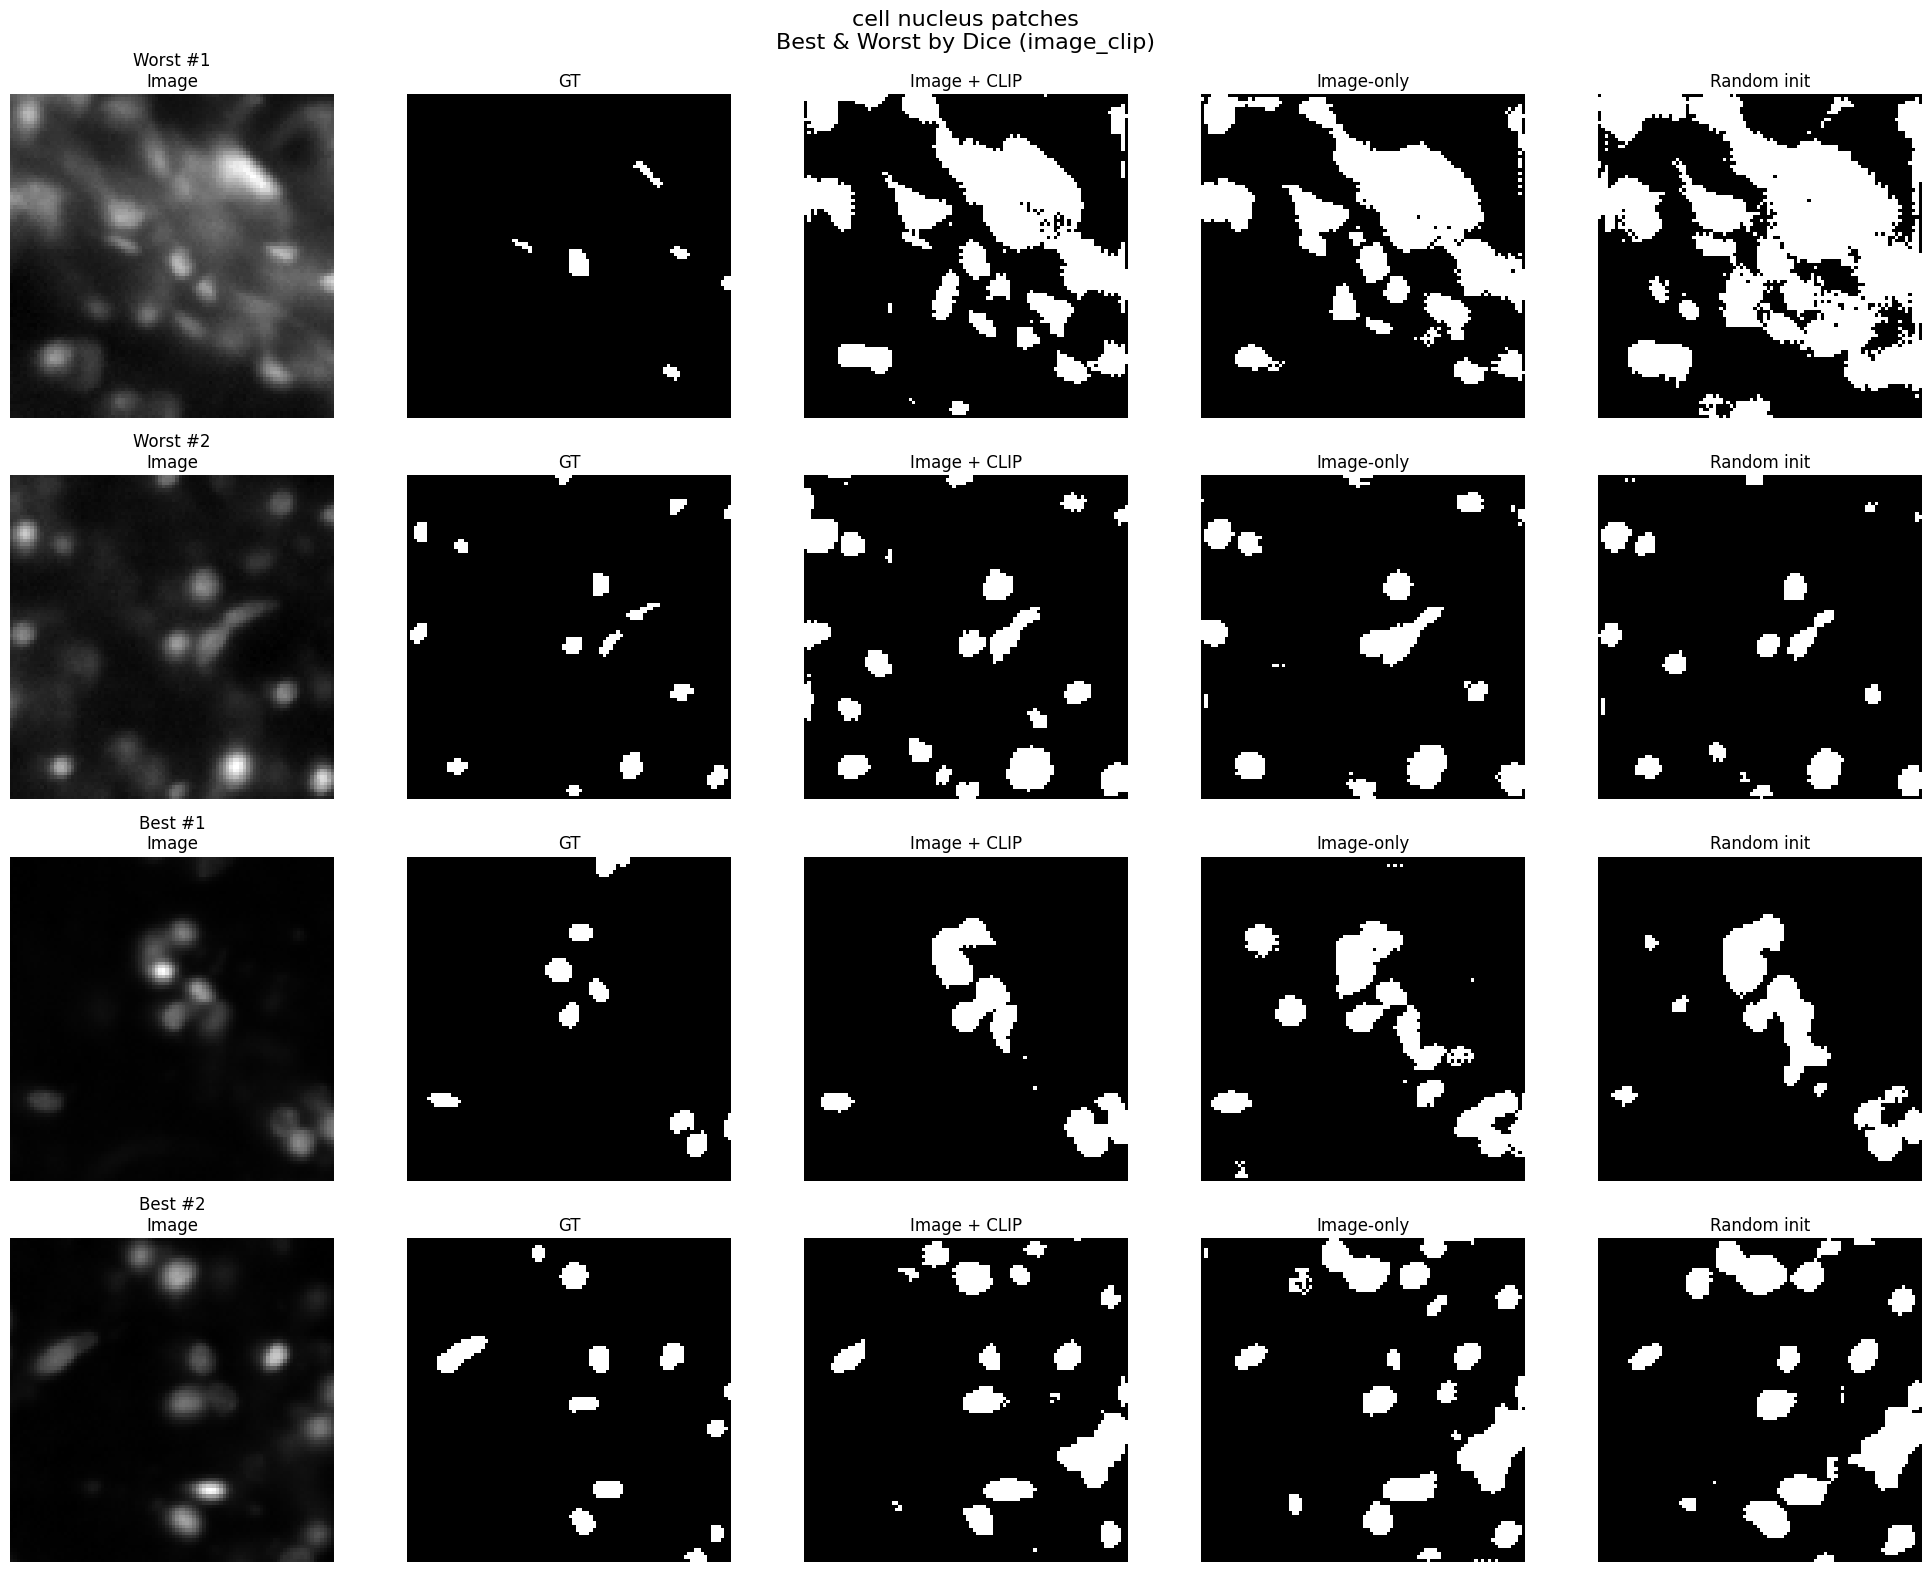

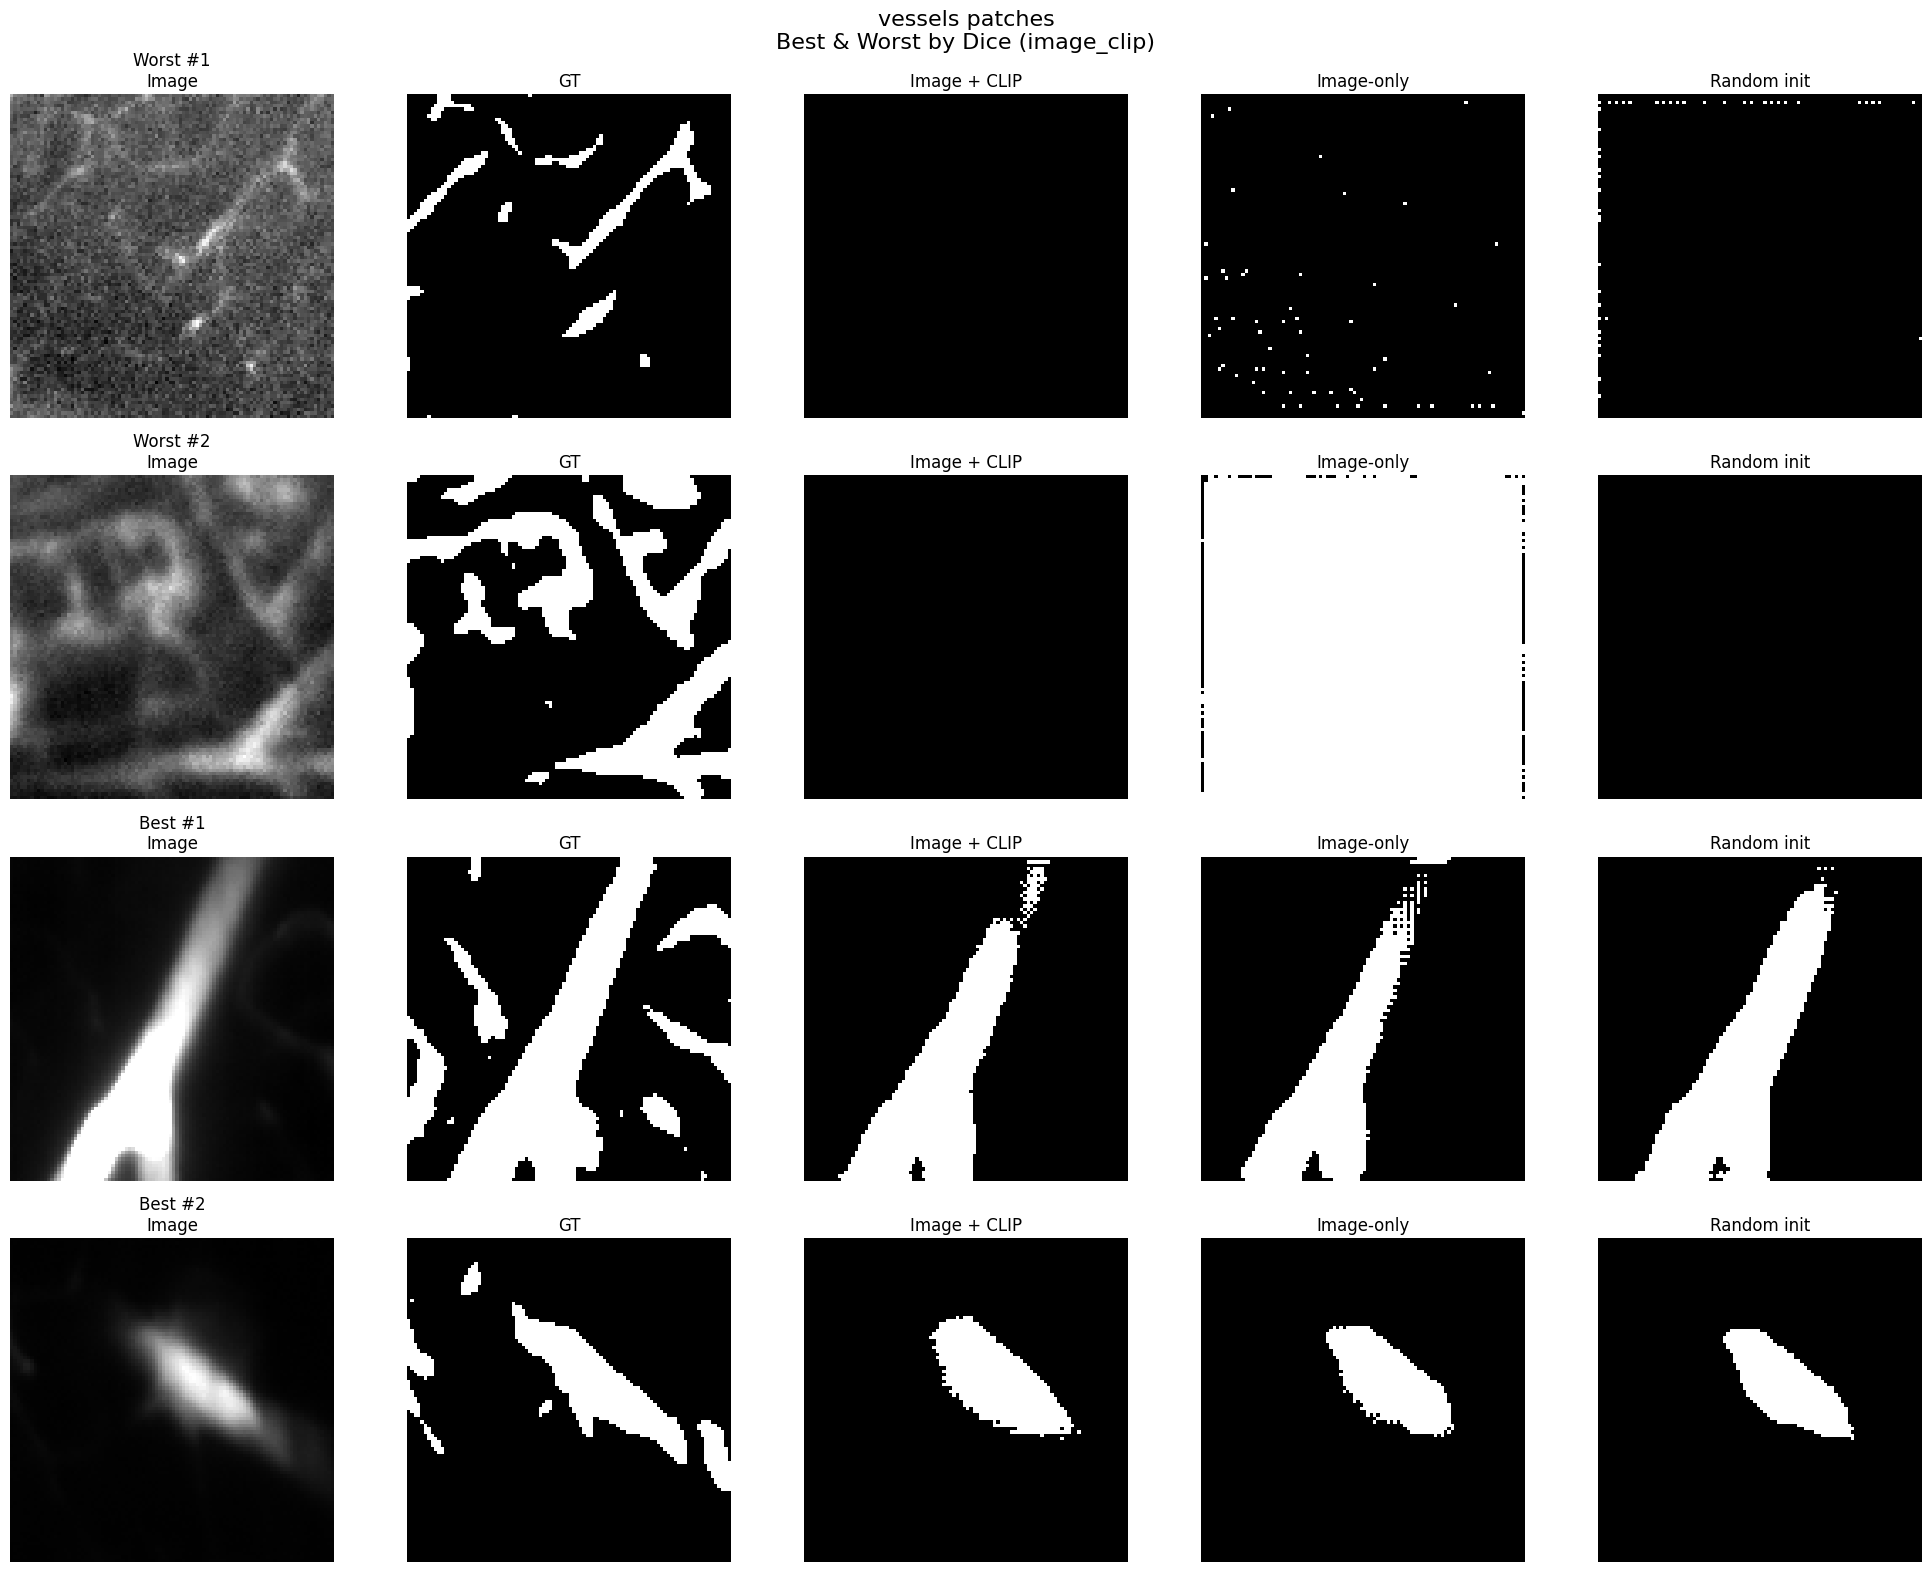

In [5]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# -----------------------------
# Paths (same as before)
# -----------------------------
DATA_ROOT = "/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches"
PRED_ROOT = "/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_zeroshot"

DATASETS = [
    "amyloid_plaque_patches",
    "c_fos_positive_patches",
    "cell_nucleus_patches",
    "vessels_patches",
]

MODELS = ["image_clip", "image_only", "random"]

MODEL_TITLES = {
    "image_clip": "Image + CLIP",
    "image_only": "Image-only",
    "random": "Random init",
}

RANK_MODEL = "image_clip"   # <<< change here if desired
N_SHOW = 2                  # best 2 + worst 2


# -----------------------------
# Utils
# -----------------------------
def load_nifti(path):
    return nib.load(path).get_fdata().astype(np.float32)

def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)


# -----------------------------
# Visualization
# -----------------------------
def show_best_worst(df, dataset):
    sub = df[(df["dataset"] == dataset) & (df["model"] == RANK_MODEL)]

    # Sort patches by Dice
    sub_sorted = sub.sort_values("dice")

    worst = sub_sorted.head(N_SHOW)
    best  = sub_sorted.tail(N_SHOW)

    selected = (
        list(worst["patch"].values) +
        list(best["patch"].values)
    )

    titles = (
        [f"Worst #{i+1}" for i in range(N_SHOW)] +
        [f"Best #{i+1}" for i in range(N_SHOW)]
    )

    n_rows = len(selected)
    n_cols = 2 + len(MODELS)

    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(4*n_cols, 4*n_rows)
    )

    for row, (patch, title) in enumerate(zip(selected, titles)):
        img_path = os.path.join(DATA_ROOT, dataset, f"{patch}.nii.gz")
        gt_path  = os.path.join(DATA_ROOT, dataset, f"{patch}_label.nii.gz")

        img = normalize(load_nifti(img_path))
        gt  = load_nifti(gt_path)

        z = img.shape[-1] // 2

        # ---- Image ----
        axes[row, 0].imshow(img[:, :, z], cmap="gray")
        axes[row, 0].set_title(f"{title}\nImage")

        # ---- Ground truth ----
        axes[row, 1].imshow(gt[:, :, z], cmap="gray")
        axes[row, 1].set_title("GT")

        # ---- Predictions ----
        for col, model in enumerate(MODELS):
            pred_path = os.path.join(
                PRED_ROOT,
                dataset,
                f"{patch}_pred_{model}.nii.gz"
            )

            if os.path.exists(pred_path):
                pred = load_nifti(pred_path)
                axes[row, 2+col].imshow(pred[:, :, z], cmap="gray")
            else:
                axes[row, 2+col].text(
                    0.5, 0.5, "MISSING",
                    ha="center", va="center"
                )

            axes[row, 2+col].set_title(MODEL_TITLES[model])

        for a in axes[row]:
            a.axis("off")

    plt.suptitle(
        f"{dataset.replace('_', ' ')}\n"
        f"Best & Worst by Dice ({RANK_MODEL})",
        fontsize=16
    )
    plt.tight_layout()
    plt.show()


# -----------------------------
# Run for all datasets
# -----------------------------
for dataset in DATASETS:
    show_best_worst(df, dataset)
